In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pymc as pm
import arviz as az

In [17]:
df = pd.read_csv("/content/BrentOilPrices.csv")

df["Date"] = pd.to_datetime(
    df["Date"],
    format="mixed",
    dayfirst=True,
    errors="coerce"
)

df = df.dropna(subset=["Date", "Price"])
df = df.sort_values("Date").reset_index(drop=True)

df.head()


,Date,Price
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


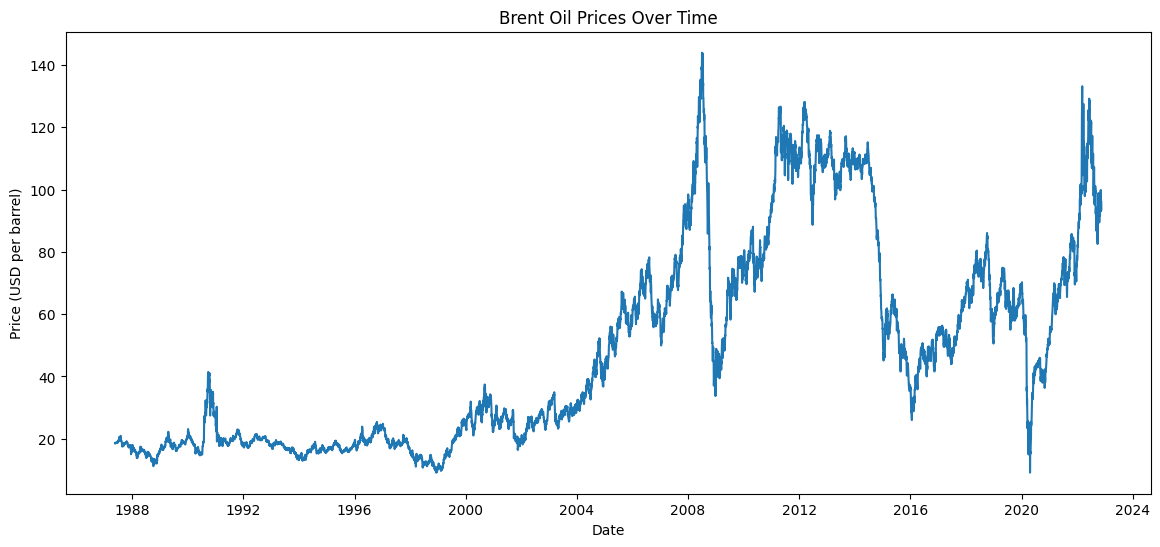

In [18]:
plt.figure(figsize=(14, 6))
plt.plot(df["Date"], df["Price"])
plt.title("Brent Oil Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Price (USD per barrel)")
plt.show()


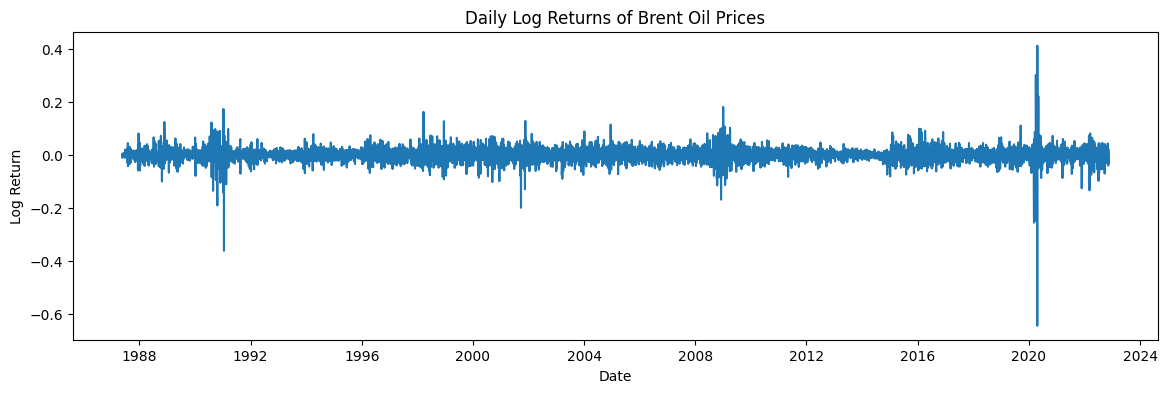

In [19]:
df["LogPrice"] = np.log(df["Price"])
df["LogReturn"] = df["LogPrice"].diff()

plt.figure(figsize=(14, 4))
plt.plot(df["Date"], df["LogReturn"])
plt.title("Daily Log Returns of Brent Oil Prices")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.show()


In [20]:
returns = df["LogReturn"].dropna().values
dates = df["Date"].iloc[1:].values  # align with returns
n = len(returns)

time_idx = np.arange(n)


In [21]:
with pm.Model() as change_point_model:


    tau = pm.DiscreteUniform(
        "tau",
        lower=0,
        upper=n - 1
    )


    mu_1 = pm.Normal("mu_1", mu=0.0, sigma=0.05)
    mu_2 = pm.Normal("mu_2", mu=0.0, sigma=0.05)


    sigma = pm.HalfNormal("sigma", sigma=0.05)


    mu = pm.math.switch(time_idx <= tau, mu_1, mu_2)


    obs = pm.Normal(
        "obs",
        mu=mu,
        sigma=sigma,
        observed=returns
    )


    trace = pm.sample(
        draws=2000,
        tune=2000,
        target_accept=0.9,
        return_inferencedata=True
    )


Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [22]:
az.summary(trace)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_1,-0.000,0.001,-0.002,0.001,0.000,0.000,1515.0,435.0,1.03
mu_2,0.000,0.001,-0.002,0.003,0.000,0.000,216.0,190.0,1.02
sigma,0.026,0.000,0.025,0.026,0.000,0.000,1372.0,1371.0,1.00
tau,4866.710,3171.971,210.000,8994.000,697.898,81.565,36.0,112.0,1.07


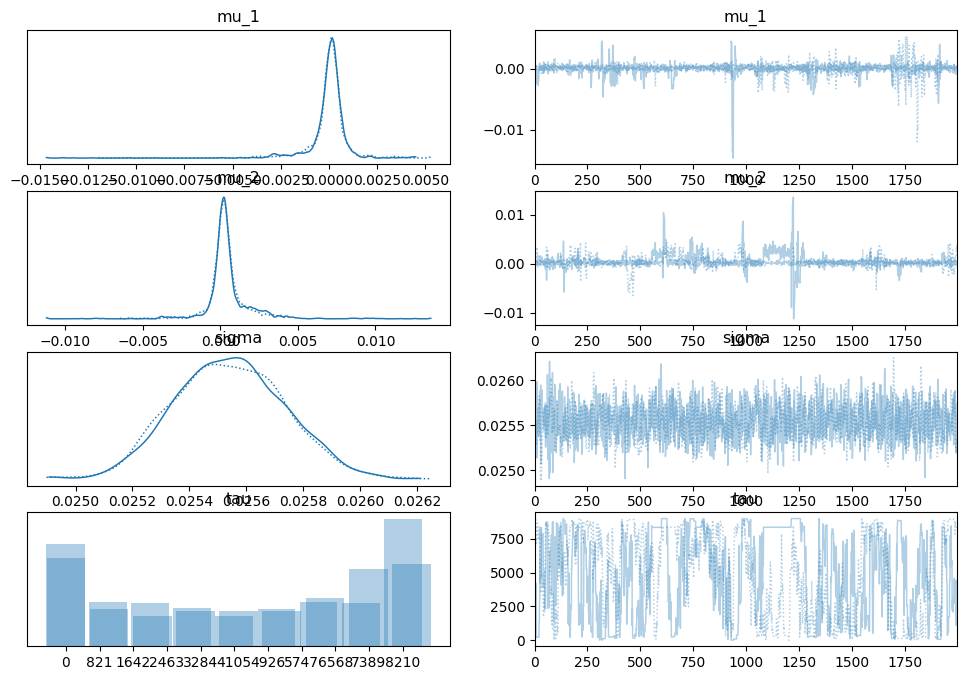

In [23]:
az.plot_trace(trace)
plt.show()

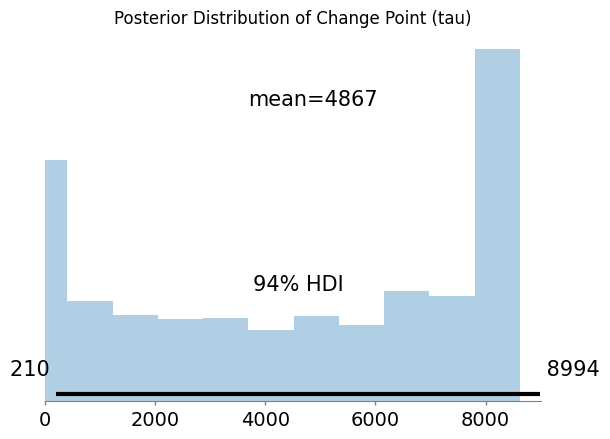

In [24]:
az.plot_posterior(trace, var_names=["tau"])
plt.title("Posterior Distribution of Change Point (tau)")
plt.show()

In [25]:
tau_samples = trace.posterior["tau"].values.flatten()

tau_mean = int(tau_samples.mean())
tau_date = dates[tau_mean]

tau_date


np.datetime64('2006-06-30T00:00:00.000000000')

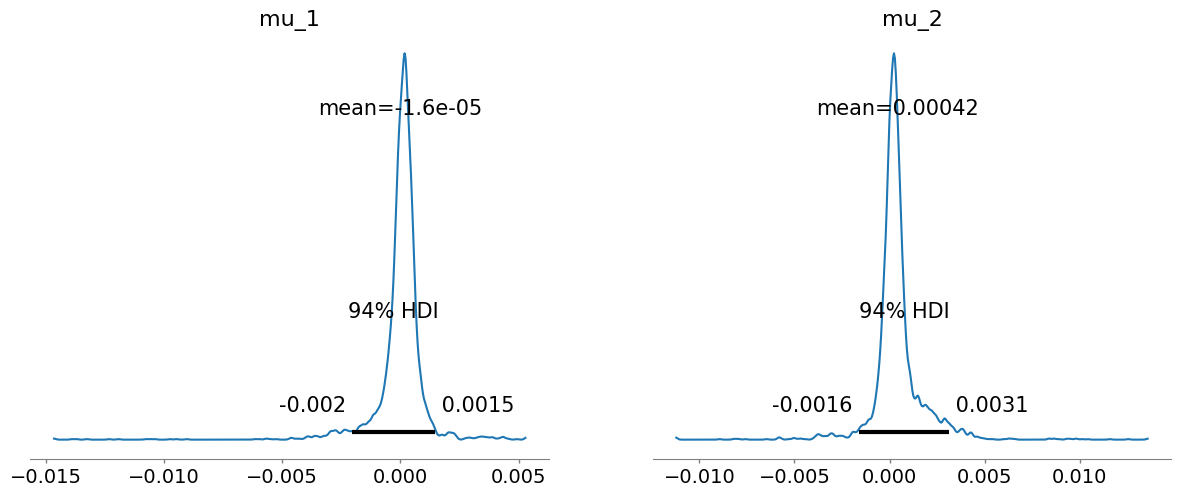

In [26]:
az.plot_posterior(trace, var_names=["mu_1", "mu_2"])
plt.show()


In [27]:
mu1_samples = trace.posterior["mu_1"].values.flatten()
mu2_samples = trace.posterior["mu_2"].values.flatten()

mean_before = mu1_samples.mean()
mean_after = mu2_samples.mean()

percent_change = (mean_after - mean_before) * 100

mean_before, mean_after, percent_change


(np.float64(-1.6060012198832983e-05),
 np.float64(0.00042058509580086985),
 np.float64(0.04366451079997028))

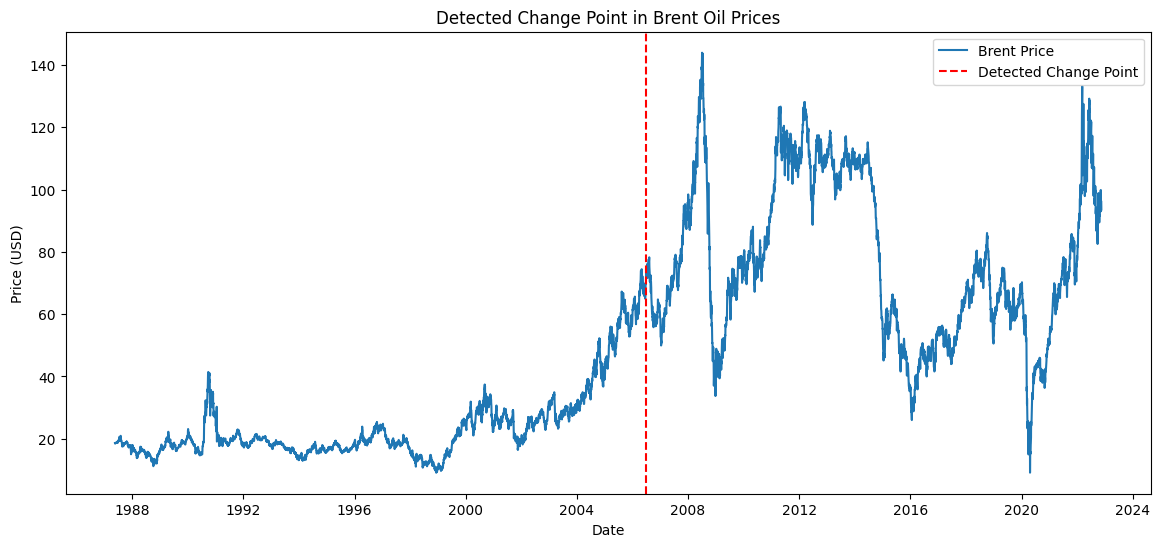

In [28]:
plt.figure(figsize=(14, 6))
plt.plot(df["Date"], df["Price"], label="Brent Price")
plt.axvline(tau_date, color="red", linestyle="--", label="Detected Change Point")
plt.legend()
plt.title("Detected Change Point in Brent Oil Prices")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.show()


In [29]:
events_df = pd.read_csv("oil_market_events.csv")
events_df["Date"] = pd.to_datetime(events_df["Date"])
events_df


,Date,Event,Category
0,2011-02-15,Arab Spring uprisings begin,Geopolitical Conflict
1,2014-11-27,OPEC decides not to cut oil production,OPEC Policy
2,2015-07-14,Iran nuclear deal signed,Sanctions
3,2016-01-16,Iran sanctions lifted,Sanctions
4,2018-05-08,US withdraws from Iran nuclear deal,Sanctions
5,2020-03-06,OPEC+ talks collapse,Price War
6,2020-03-11,WHO declares COVID-19 a pandemic,Global Shock
7,2020-04-12,OPEC+ historic production cut,OPEC Policy
8,2022-02-24,Russia invades Ukraine,Geopolitical Conflict
9,2022-03-08,US bans Russian oil imports,Sanctions


In [30]:
events_df["DaysFromChange"] = (
    events_df["Date"] - tau_date
).dt.days.abs()

closest_event = events_df.sort_values("DaysFromChange").iloc[0]
closest_event


,0
Date,2011-02-15 00:00:00
Event,Arab Spring uprisings begin
Category,Geopolitical Conflict
DaysFromChange,1691
